# References
1.   https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

2.   https://pytorch.org/tutorials/beginner/fgsm_tutorial.html


# Task 1

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [3]:
print(torch.cuda.is_available())

True


In [4]:
device = torch.device("cuda")
print(device)

cuda


In [5]:
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
EPOCHS = 14
LEARNING_RATE = 0.001
GAMMA = 0.7
SEED = 42
LOG_INTERVAL = 250
SAVE_MODEL = False

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [7]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [8]:
def check_train(model, device, train_loader):
    model.eval()
    train_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            train_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))


In [9]:
train_kwargs = {'batch_size': BATCH_SIZE}
test_kwargs = {'batch_size': BATCH_SIZE}
cuda_kwargs = {'num_workers': 1,
                'pin_memory': True,
                'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)

In [10]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=LEARNING_RATE)

100%|██████████| 9912422/9912422 [00:00<00:00, 387963413.50it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 111133664.06it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 177167009.85it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2950825.40it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



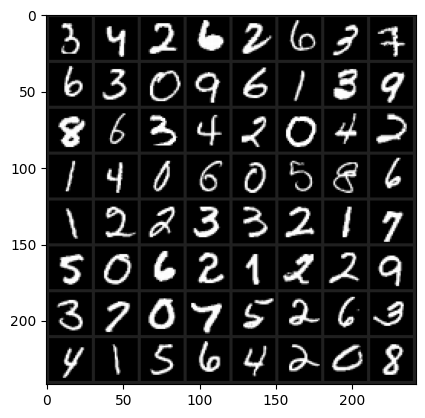

    3     4     2     6     2     6     3     7     6     3     0     9     6     1     3     9     8     6     3     4     2     0     4     2     1     4     0     6     0     5     8     6     1     2     2     3     3     2     1     7     5     0     6     2     1     2     2     9     3     7     0     7     5     2     6     3     4     1     5     6     4     2     0     8


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray')  # Show single-channel image
    plt.show()


# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(len(labels))))

In [12]:
scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)
for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.279073
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.200493
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.071344
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.846418

Test set: Average loss: 1.6063, Accuracy: 7797/10000 (78%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.653892
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.406271
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.385469
Train Epoch: 2 [48000/60000 (80%)]	Loss: 1.144876

Test set: Average loss: 0.9602, Accuracy: 8271/10000 (83%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.230458
Train Epoch: 3 [16000/60000 (27%)]	Loss: 1.051938
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.966580
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.948427

Test set: Average loss: 0.7326, Accuracy: 8475/10000 (85%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.925329
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.991485
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.822841
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.920737

Test set: Average loss: 0.6375, Accu

In [13]:
check_train(model, device, train_loader)


Train set: Average loss: 0.5336, Accuracy: 51953/60000 (87%)



In [14]:
classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [15]:
torch.save(model.state_dict(), "mnist_cnn.pt")

As is observed for the above case - on using a model trained from scratch, during test, we obtain good performance, with overall 87.81% accuracy on the test dataset, and an overall accuracy of 86.59% for the train dataset.

# Task 2

In [16]:
model.load_state_dict(torch.load("mnist_cnn.pt", map_location=device))

<All keys matched successfully>

In [17]:
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

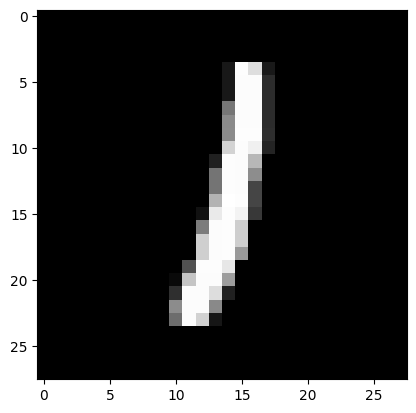

    1


In [19]:
# Get some random training images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(len(labels))))

In [20]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [23]:
def test( model, device, test_loader, epsilon, attack, attack_name ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Attack: {attack_name}\tEpsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [24]:
accuracies = []
examples = []
epsilons = [0, 0.05, 0.125, 0.25]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, fgsm_attack, 'FGSM - Untargeted')
    print(acc)

    accuracies.append(acc)
    examples.append(ex)

Attack: FGSM - Untargeted	Epsilon: 0	Test Accuracy = 8781 / 10000 = 0.8781
0.8781
Attack: FGSM - Untargeted	Epsilon: 0.05	Test Accuracy = 8028 / 10000 = 0.8028
0.8028
Attack: FGSM - Untargeted	Epsilon: 0.125	Test Accuracy = 6140 / 10000 = 0.614
0.614
Attack: FGSM - Untargeted	Epsilon: 0.25	Test Accuracy = 1426 / 10000 = 0.1426
0.1426


In [30]:
from tabulate import tabulate

# Define the table headers and data
headers = ["Attack Type", "Clean Accuracy", "ε1:0.05", "ε2:0.125", "ε3:0.25"]
data = [
    ["FGSM (Untargeted)", 0.8781, 0.8028, 0.614, 0.1426]
]

# Print the table
print(tabulate(data, headers=headers, tablefmt="grid"))

+-------------------+------------------+-----------+------------+-----------+
| Attack Type       |   Clean Accuracy |   ε1:0.05 |   ε2:0.125 |   ε3:0.25 |
+===================+==================+===========+============+===========+
| FGSM (Untargeted) |           0.8781 |    0.8028 |      0.614 |    0.1426 |
+-------------------+------------------+-----------+------------+-----------+


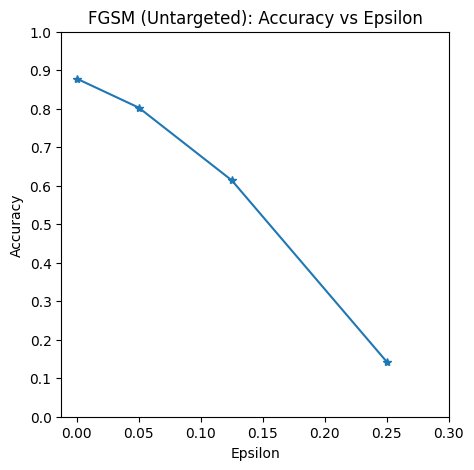

In [25]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("FGSM (Untargeted): Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

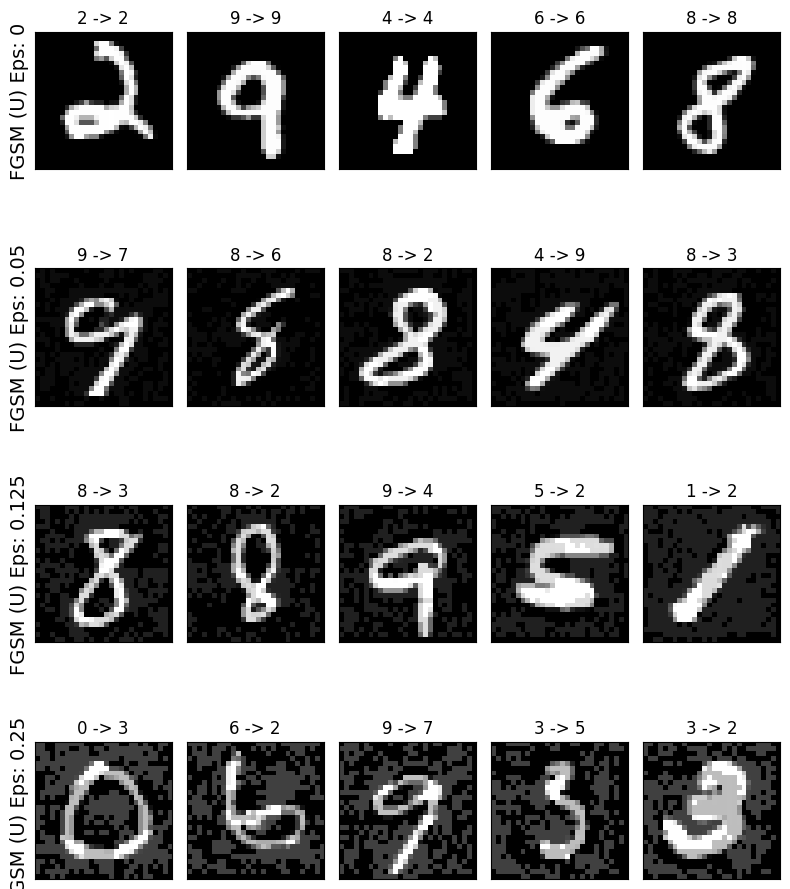

In [28]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"FGSM (U) Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()